# Jugement majoritaire

* https://youtu.be/ZoGH7d51bvc?si=5tCFgVWBWttHCvl1&t=917
* https://scienceetonnante.com/2016/10/21/reformons-lelection-presidentielle/
* Rida Laraki et Michel Balinski 

A chaque candidat on donne une mention :

1. A rejeter
1. Insuffisant
1. Passable
1. Assez Bien
1. Bien
1. Très Bien
1. Excellent

* Les candidats en colonne
* Les Notes (features) en ligne
* De Excellent à A rejeter on fait la somme cumulée
* Quand la somme cumulée dépasse 50% alors on a la Mention Majoritaire du candidat. Par exemple, 57 % de la population lui accorde AB
* Une fois la matrice remplie
* On tire un trait à 50%
* Le candidat qui a la meilleure mention majoritaire a gagné. En cas d'égalité on regarde les valeurs des %

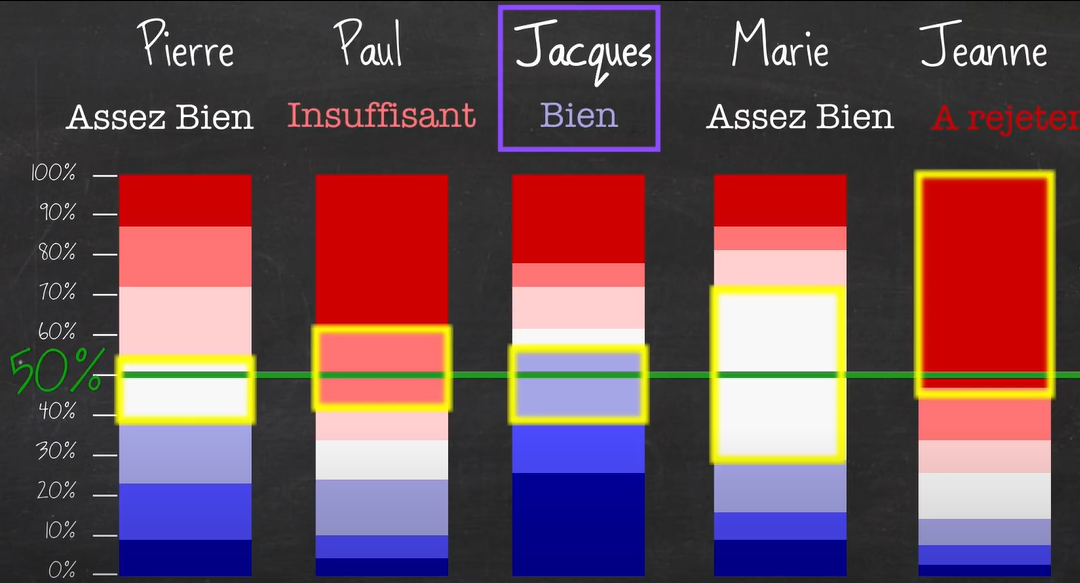



In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [167]:
s_mentions = pd.Series([ "Excellent", "Très bien", "Bien", "Assez bien", "Passable", "Insuffisant", "À rejeter",], name='Mentions')

df = pd.DataFrame({
  s_mentions.name : s_mentions,
  "Pierre"        : [ 9, 14, 16, 15, 18, 15, 13,],
  "Paul"          : [ 6,  5, 18, 10,  8, 14, 39,],
  "Jacques"       : [25, 15, 15,  5, 10,  8, 22,],
  "Marie"         : [10,  5, 10, 45, 10,  8, 12,],
  "Jeanne"        : [ 4,  5,  6, 12,  9, 10, 54,]
})

df = df.set_index('Mentions')
print(df.head(10))


             Pierre  Paul  Jacques  Marie  Jeanne
Mentions                                         
Excellent         9     6       25     10       4
Très bien        14     5       15      5       5
Bien             16    18       15     10       6
Assez bien       15    10        5     45      12
Passable         18     8       10     10       9
Insuffisant      15    14        8      8      10
À rejeter        13    39       22     12      54


<Axes: >

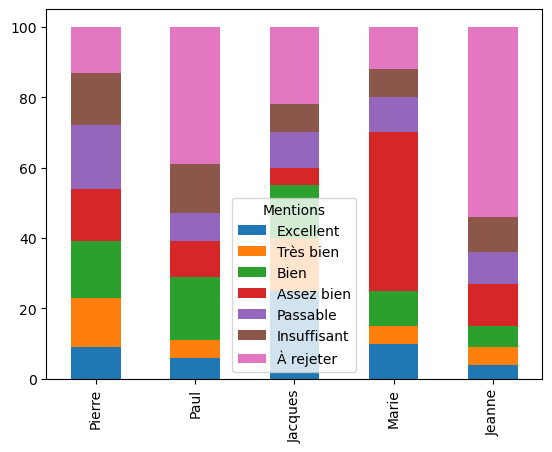

In [168]:
# tres moche
dft=df.transpose()
dft.plot(kind='bar', stacked=True)
# TODO : tracer une ligne à 50%

In [169]:
print(dft.head())

Mentions  Excellent  Très bien  Bien  Assez bien  Passable  Insuffisant  \
Pierre            9         14    16          15        18           15   
Paul              6          5    18          10         8           14   
Jacques          25         15    15           5        10            8   
Marie            10          5    10          45        10            8   
Jeanne            4          5     6          12         9           10   

Mentions  À rejeter  
Pierre           13  
Paul             39  
Jacques          22  
Marie            12  
Jeanne           54  


In [170]:
df.cumsum()

,Pierre,Paul,Jacques,Marie,Jeanne
Mentions,,,,,
Excellent,9,6,25,10,4
Très bien,23,11,40,15,9
Bien,39,29,55,25,15
Assez bien,54,39,60,70,27
Passable,72,47,70,80,36
Insuffisant,87,61,78,88,46
À rejeter,100,100,100,100,100


In [171]:
resultats = df.cumsum().ge(50).idxmax()
resultats.name="mention"
print(resultats)

Pierre      Assez bien
Paul       Insuffisant
Jacques           Bien
Marie       Assez bien
Jeanne       À rejeter
Name: mention, dtype: object


# Afficher classement dans l'ordre

* créer un dataframe et y inclure la colonne "resultats"
* ajouter une colone "valeur_mention"
* Pour chaque valeur de resultats
* Retrouver l'indice de la mention dans s_mention
* la coller dans la colonne valeur_mention

In [172]:
df_mentions = pd.DataFrame({
  resultats.name : resultats,
})

my_list=[]
for m in resultats:
  indice = s_mentions.index[s_mentions == m].tolist()[0]
  my_list.append(indice)



df_mentions["valeur_mention"] = my_list
print(df_mentions.sort_values(by="valeur_mention"))


             mention  valeur_mention
Jacques         Bien               2
Pierre    Assez bien               3
Marie     Assez bien               3
Paul     Insuffisant               5
Jeanne     À rejeter               6


# Affiner les ex aequo

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Hard Voting

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [175]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


# Soft Voting

In [176]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)           # ! proba = True

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [177]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__} : {accuracy_score(y_test, y_pred):.3f}")

LogisticRegression : 0.864
RandomForestClassifier : 0.896
SVC : 0.896
VotingClassifier : 0.920
